# Automatic Image Colorization Using Deep Learning

# STEPS:
1)Importing Libraries and Defining Display Function

2)Loading Pre-trained Models and Configuration

3)Colorization Function

4)Directory Paths and Processing Loop- OUTPUT DISPLAY

# Importing Libraries and Defining Display Function

*  Imports necessary libraries (cv2 for OpenCV, numpy for numerical operations, matplotlib.pyplot for visualization, and os for file operations)
*  and defines a function (display_images_side_by_side) to display two images side by side in a grid layout.

In [1]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Function to display images in Jupyter Notebook side by side
def display_images_side_by_side(image1, image2, title1="Image 1", title2="Image 2"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    axes[0].set_title(title1)
    axes[0].axis('off')
    axes[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    axes[1].set_title(title2)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

# Loading Pre-trained Models and Configuration

* Utilizes OpenCV's 'cv2.dnn.readNetFromCaffe' function to load the model architecture and weights.
* Loads cluster centers ('pts_in_hull.npy') for mapping grayscale to color channels.
* Configures the model layers ('class8_ab' and 'conv8_313_rh') with necessary parameters for correct colorization predictions.

In [3]:
# Load the pre-trained models
net = cv2.dnn.readNetFromCaffe('models/colorization_deploy_v2.prototxt', 'models/colorization_release_v2.caffemodel')
pts = np.load('models/pts_in_hull.npy')

In [4]:
# Add the cluster centers as 1x1 convolutions to the model
class8 = net.getLayerId('class8_ab')
conv8 = net.getLayerId('conv8_313_rh')
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype(np.float32)]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, np.float32)]

# Colorization Function

* Loads the black and white image, converts it to grayscale and then to LAB color space.
* Normalizes the image values for processing.
* Resizes and extracts the L channel, subtracting a mean value ('50') for proper centering.
* Feeds the L channel into the pre-trained model ('net') to predict AB channels ('ab').
* Combines the L and AB channels back into LAB color space and converts it to BGR.
* Clips the values to the valid range, saves the colorized image ('output_path') as a BGR image.

In [5]:
def colorize_image(bw_image_path, output_path):
    # Load the grayscale image
    bw_image = cv2.imread(bw_image_path)
    if bw_image is None:
        print(f"Error: Unable to load image {bw_image_path}")
        return
    bw_image = cv2.cvtColor(bw_image, cv2.COLOR_BGR2GRAY)
    bw_image = cv2.cvtColor(bw_image, cv2.COLOR_GRAY2BGR)

    # Normalize the image
    normalized = bw_image.astype('float32') / 255.0
    lab = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB)
    resized = cv2.resize(lab, (224, 224))

    # Extract the L channel and subtract 50 for mean-centering
    L = resized[:, :, 0]
    L -= 50

    # Run the model to predict the AB channels
    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    # Resize the result and concatenate with the original L channel
    ab = cv2.resize(ab, (bw_image.shape[1], bw_image.shape[0]))
    LAB_colored = np.concatenate((lab[:, :, 0][:, :, np.newaxis], ab), axis=2)

    # Convert back to BGR
    BGR_colored = cv2.cvtColor(LAB_colored, cv2.COLOR_LAB2BGR)
    BGR_colored = np.clip(BGR_colored, 0, 1) * 255
    BGR_colored = BGR_colored.astype('uint8')

    # Save the output
    cv2.imwrite(output_path, BGR_colored)

# Directory Paths and Processing Loop

* Creates the output folder if it doesn't exist.
* Iterates through each image file in the input folder ('os.listdir(input_folder)'), skipping hidden files ('like .ipynb_checkpoints').
* Constructs input and output paths for each image. Calls colorize_image to process each image and saves the resulting colorized image.
* Loads both the original black and white image ('bw_image') and the colorized image ('colorized_image').
* Displays them side by side using display_images_side_by_side function if both images are successfully loaded, or prints an error message if not.

In [6]:
# Directory paths
input_folder = 'images'
output_folder = 'output'

In [7]:
# Create the output directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

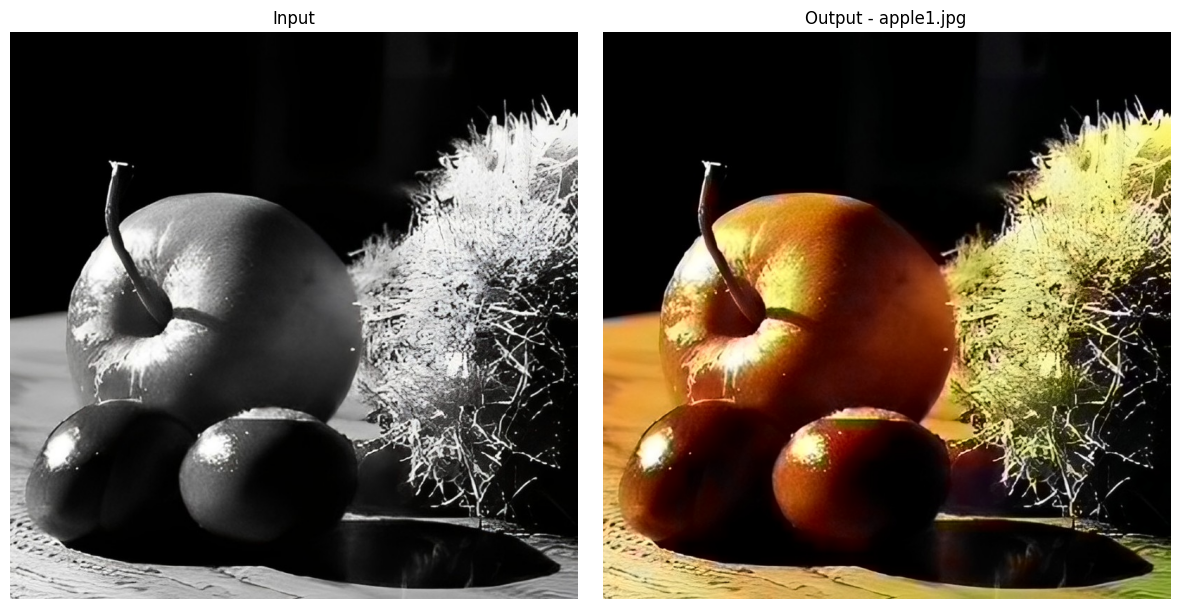

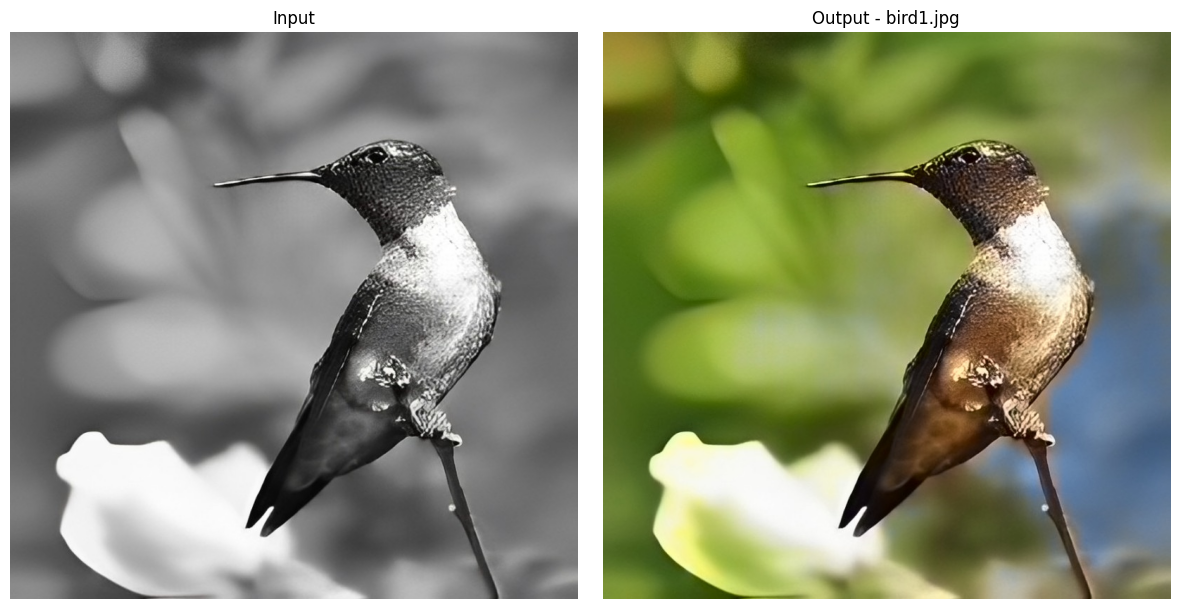

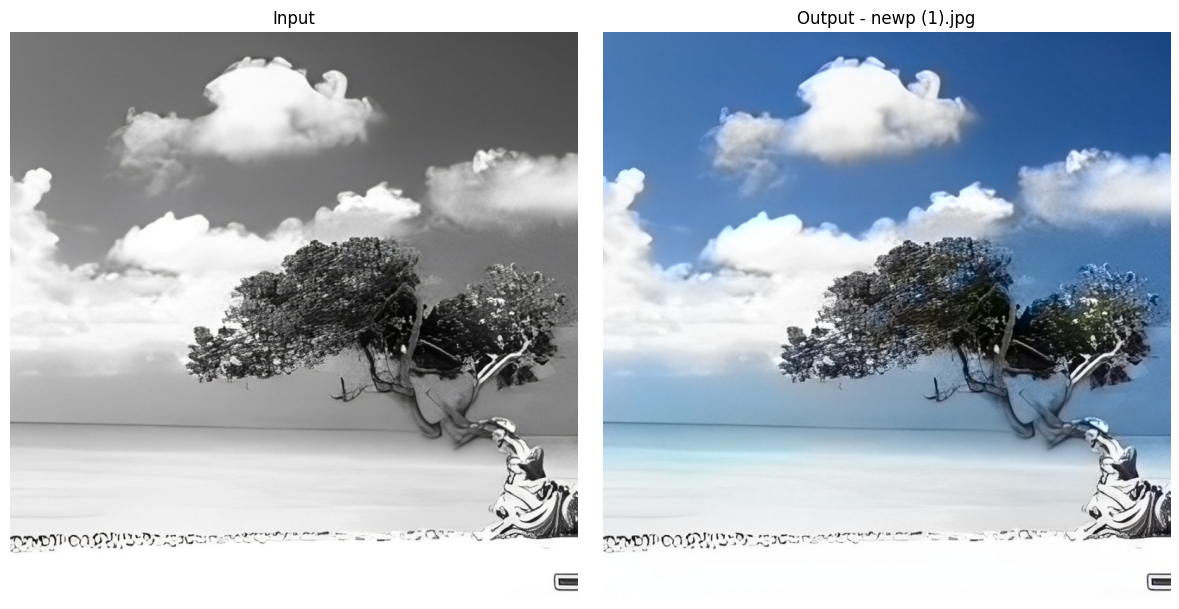

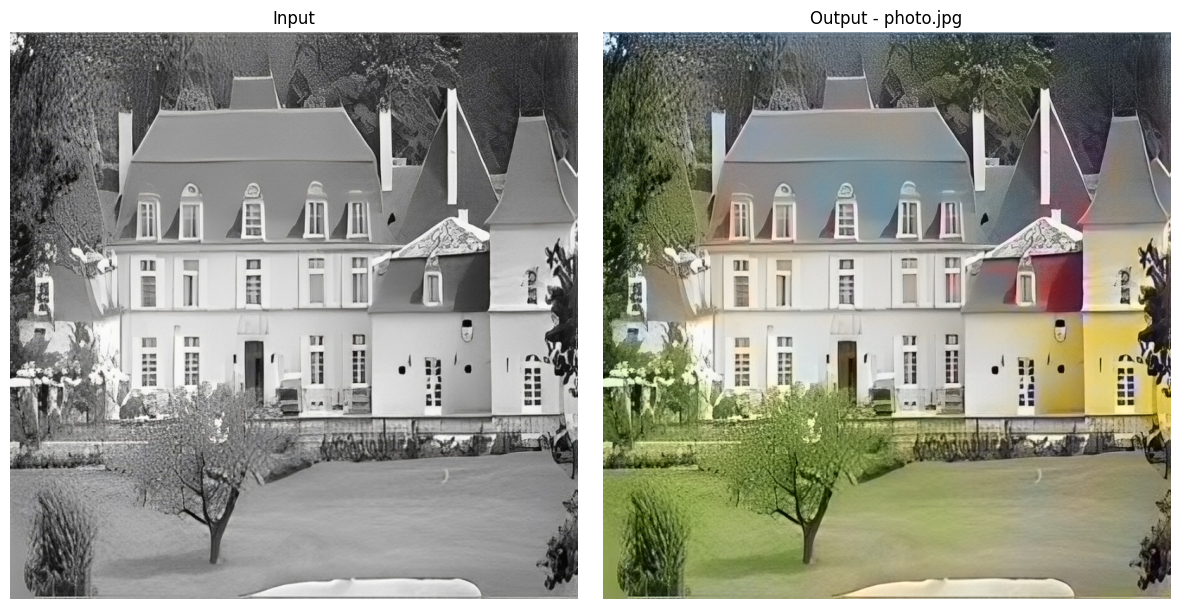

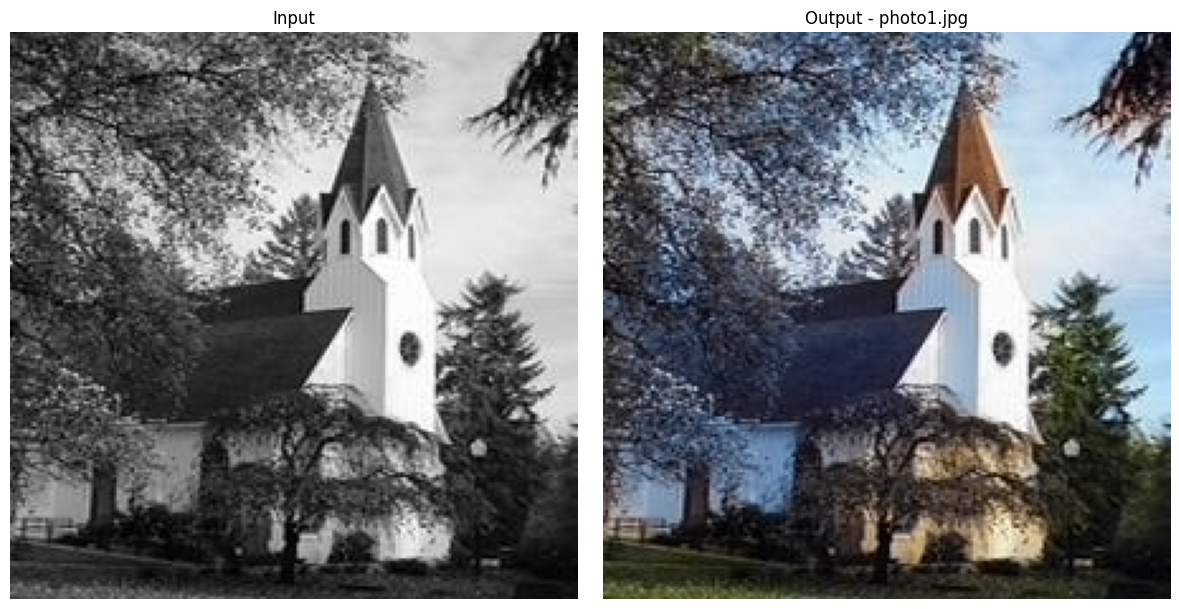

In [8]:
# Process each image in the input folder
for image_name in os.listdir(input_folder):
    # Skip hidden files and directories
    if image_name.startswith('.'):
        continue
    
    input_path = os.path.join(input_folder, image_name)
    output_path = os.path.join(output_folder, image_name)

    colorize_image(input_path, output_path)

    # Display side by side
    bw_image = cv2.imread(input_path)
    colorized_image = cv2.imread(output_path)
    if bw_image is not None and colorized_image is not None:
        display_images_side_by_side(bw_image, colorized_image, title1="Input", title2="Output - " + image_name)
    else:
        print(f"Error: Unable to display images {image_name}")